# Model 1_2
## Dataset: MNIST FASHION from KERAS

## Programmer: Giovanni Vecchione
## Date: 4/10/24
## Subject: Machine Learning 2 - Project 5
Use Generative Adversarial Networks (GAN)  to build the project. Submit your project as Jupyter notebook

Goal: Create a fashion image generator using a GAN.

# **What is a Generative Adversarial Network (GAN)?**

#### **The Art of Imitation:** GANs are a type of deep learning architecture where two neural networks are locked in an elaborate game of cat-and-mouse.  Think of them as a master art forger and an expert art critic:
   **The Generator:** The 'art forger' responsible for creating realistic fakes that could pass as authentic pieces (e.g., images, music, text etc.).
     
   **The Discriminator:**  The 'art critic'  trained to tell the difference between a genuine masterpiece and the generator's forgeries.

#### **A Competitive Game:**  Both networks get better through this competition.  The generator keeps refining its fakes to fool the discriminator, and the discriminator gets better at spotting the subtle flaws in those fakes. Over time, the generator gets so good that its creations become indistinguishable from real data.

## Basic Concepts

1. **Unsupervised Learning:** GANs don't need labeled data. They learn from a dataset of examples (e.g., a collection of real photographs), extracting the patterns and underlying structure without explicit labels like "dog" or "cat."

2. **Generator Network:**
   * Takes random noise as input.
   * Tries to transform that noise into data that resembles the real examples it has seen.
   * Its goal is to make the discriminator believe its outputs are real.

3. **Discriminator Network:**
   * Takes as input both real data samples and the generator's outputs.
   * Tries to classify whether an input is "real" (from the training dataset) or "fake" (created by the generator).
   * Gives feedback to the generator to help it improve its fakes.

4. **Adversarial Training:**
   * The generator and discriminator are trained simultaneously.
   * The generator improves by making the discriminator's job harder.
   * The discriminator improves by becoming a better judge of authenticity.
   * It's this constant push-and-pull that makes GANs so powerful.

**Why use GANs?**

* **Generating New Data:** Create realistic images, music, videos, or other data forms that weren't in your original dataset.
* **Data Augmentation:** Increase the size and diversity of a dataset, useful in areas where real data is scarce.
* **Image-to-Image Translation:** Change images from one style to another (e.g., turning sketches into photos).
* **Super Resolution:** Enhancing image or video quality.

**Ready to Build?**

Building a GAN involves:

* **Choosing Your Domain:**  Images, text, audio, etc.
* **Data Preparation:**  Gathering or creating a suitable dataset.
* **Network Architecture:**  Designing your generator and discriminator networks (often using convolutional neural networks for images).
* **Training Setup:**  Defining the loss functions that guide the networks and selecting an optimization algorithm. 
* **Implementation:**  Coding your GAN using a deep learning framework like TensorFlow or PyTorch.




In [25]:
import tensorflow as tf
import tensorflow_datasets as tfds
import random
import torch
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
from keras.regularizers import l1
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense
from sklearn.utils import class_weight
from tensorflow.keras import backend as K 
from keras.preprocessing.sequence import pad_sequences 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA


import re

seed = 42
random.seed(seed)

In [26]:
#Checks if GPU is being used
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use the GPU
    print("Using GPU:", torch.cuda.get_device_name(0)) 
else:
    device = torch.device("cpu")  # Fallback to CPU
    print("GPU not available, using CPU.")

#Using GPU: NVIDIA GeForce GTX 1660 SUPER - Successful
#NOTE: This took some time to set up by installing and pathing the cuda toolkit v.12.4 and the right supplemental packages. This drastically improved
#training time

Using GPU: NVIDIA GeForce GTX 1660 SUPER


In [27]:
#import Dataset
fashion_mnist = tf.keras.datasets.fashion_mnist

#split dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Limit Dataset Sizes
train_images = train_images[:6000]
train_labels = train_labels[:6000]
test_images = test_images[:3000]
test_labels = test_labels[:3000]

In [28]:
#Preprocessing:

# Data Conversion and Normalization
train_images = tf.cast(train_images, tf.float32)  # Convert to float32 / this type is needed, MNIST is unit8 type
train_images /= 255.0  # Normalize to [0, 1] range

# Do the same for the test dataset if needed:
test_images = tf.cast(test_images, tf.float32)
test_images /= 255.0  

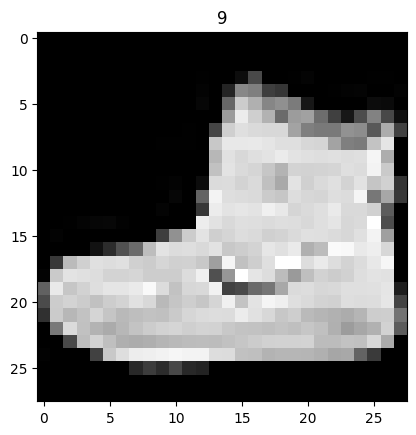

In [29]:
# Let's look at the first image and its label
plt.imshow(train_images[0], cmap='gray')
plt.title(train_labels[0])
plt.show()

In [30]:
codings_size = 100

generator = tf.keras.Sequential([
    tf.keras.layers.Dense(7 * 7 * 128),
    tf.keras.layers.Reshape([7, 7, 128]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2,
                                    padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2,
                                    padding="same", activation="tanh"),
])
discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="same",
                           activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same",
                           activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
gan = tf.keras.Sequential([generator, discriminator])

In [31]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [32]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size=1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Since the training loop is unusual, we cannot use the regular fit() method. Instead, we will write a custom training loop. For this, we first need to create a Dataset to iterate through the images:

In [33]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs):
    generator, discriminator = gan.layers

    display_interval = 1  # Display images every 5 epochs
    num_images_to_display = 2 

    for epoch in range(n_epochs):
        for X_batch in dataset:

            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, tf.expand_dims(X_batch, axis=-1)], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator_loss = discriminator.train_on_batch(X_fake_and_real, y1)
            print(f"Discriminator Loss: {discriminator_loss}") 

            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            generator_loss = gan.train_on_batch(noise, y2)
            print(f"Generator Loss: {generator_loss}")

        # Image Visualization
        if (epoch + 1) % display_interval == 0: 
            
            noise = tf.random.normal([num_images_to_display, codings_size])
            generated_images = generator(noise)

            plt.figure(figsize=(8, 8))
            for i in range(generated_images.shape[0]):
                plt.subplot(4, 4, i+1)
                img = generated_images[i, :, :, :]
                plt.imshow(img)
                plt.axis('off')

            plt.tight_layout()

            # Debugging 
            print("About to save image...")  
            print(f"Shape of generated_images: {generated_images.shape}")

            plt.savefig(f"generated_images_GAN/generated_images_epoch{epoch + 1}.png") #Have to create a folder named "generated_images_GAN" in the same project file.
            plt.close()



In [37]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=20)

Discriminator Loss: 1.0839431285858154
Generator Loss: 0.2545773386955261
Discriminator Loss: 1.0947057008743286
Generator Loss: 0.26304519176483154
Discriminator Loss: 1.1077325344085693
Generator Loss: 0.2662310004234314
Discriminator Loss: 1.1167733669281006
Generator Loss: 0.2748752236366272
Discriminator Loss: 1.1305452585220337
Generator Loss: 0.2777939736843109
Discriminator Loss: 1.1394826173782349
Generator Loss: 0.28356581926345825
Discriminator Loss: 1.1493325233459473
Generator Loss: 0.2908141016960144
Discriminator Loss: 1.1618577241897583
Generator Loss: 0.29459601640701294
Discriminator Loss: 1.1714273691177368
Generator Loss: 0.3011634051799774
Discriminator Loss: 1.1812937259674072
Generator Loss: 0.3055483400821686
Discriminator Loss: 1.1909265518188477
Generator Loss: 0.3114650547504425
Discriminator Loss: 1.2011443376541138
Generator Loss: 0.3149050176143646
Discriminator Loss: 1.2101919651031494
Generator Loss: 0.3190280795097351
Discriminator Loss: 1.2192394733428

In [35]:
codings = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator.predict(codings)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


# Testing:

### Test #1:

Attempting the to train the model, it seems to be running however I don't seem to see anyway to output training images.

### Test #2:

Found the issue, it seems I accidently nested the image generation inside another loop causing a repetitive loop output.

### Test #3: 

Issues with training, however this seems to be due to the dataset. I loaded the entire library to train on rather than a limited amount meaning training time per epoch would take quite sometime. I reduced the size of the dataset to see if it improves.

    Results: Adjusting size of dataset to a more managable size has vastly improved training time. From here I will work on tweaking some parameters.

### Test #4:

Testing generated images from baseline settings that I set.

    Results: Images are outputting, however unsure if this is correctly generating the images I would like.

### Test #5:

The generator and discriminator are training correctly. Discriminator is curently quite good at distinguishing real and fake images although there may be some possible fixes here. The ideal loss is around 0.69 for this task, but not unreasonably high.
A relatively low loss (0.26) indicates that your generator is somehow "fooling" the discriminator.  However, this doesn't necessarily mean it's generating good Fashion MNIST-like images yet.

    Generator Loss: 0.2652607858181
    Discriminator Loss: 1.431471824645996
    Generator Loss: 0.265164315700531
    Discriminator Loss: 1.4315727949142456
    Generator Loss: 0.2650805413722992
    About to save image...
    Shape of generated_images: (2, 28, 28, 1)

    Results: It's too soon to determine if there is any meaningful changes and adjustments. This is primarly due to my GPU taking some time to process the images even with a limited dataset. I find this impratical to test for anyone not running a subpar GPU in which it seems most students don't have available. In my case, I do have one and it still takes roughly 3 to 4 minutes a epoch. Suggest changing epochs to a larger number.

### Test #5.1:

After almost 1 hour this seems to have done some improvements, the pixelated photos resemble the basic shape of the clothing but nothing too obvious. However this is promising.

### Test #6:

Added code to allow the images to show during the end of each epoch. 

    Results: It works

    ![GAN image.PNG](<attachment:GAN image.PNG>)

### Test #7:

I will pause here for now but from what I can tell the model appears to be working correctly and with a basic dataset this could be swapped to something more complex down the line.

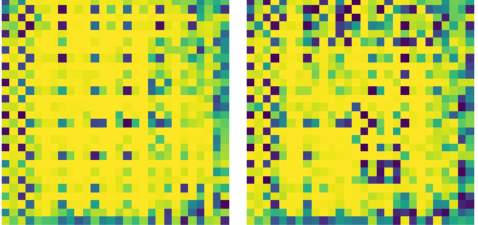